In [1]:
import xml.etree.ElementTree as ET
import collada, time, numpy as np, uuid, sys
from math import pi
import json, requests
import os
import zipfile
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
import numpy as np

In [2]:
model_path = '/home/ruslan/.ignition/fuel/fuel.ignitionrobotics.org/openrobotics/models/'

world_name = 'finals_practice_03'
# world_name = 'simple_tunnel_02'

world_path = f'/home/ruslan/CTU/subt_ws/src/subt/subt_ign/worlds/{world_name}.sdf'
# world_path = f'/home/ruslan/CTU/python3_ws/src/rpz_planning/data/worlds/{world_name}.world'

In [3]:
def find_character_in_string(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

In [4]:
def get_sdf_path(model_path, model_name):
    sdf_path = os.path.join(
        model_path + model_name,
        os.listdir(model_path + model_name)[0],
        'model.sdf')
    return sdf_path


def find_root_sdf(model_name):
    
    if model_name == 'tunnel_staging_area':
        model_name = 'subt_tunnel_staging_area'
    elif model_name == 'Extinguisher':
        model_name = 'Fire Extinguisher'

    root_sdf = None

    try:
        model_name = model_name.lower()
        sdf_path = get_sdf_path(model_path, model_name)
        root_sdf = ET.parse(sdf_path).getroot()
    except FileNotFoundError:
        try:
            model_name = model_name.lower().replace(' ', '_')
            sdf_path = get_sdf_path(model_path, model_name)
            root_sdf = ET.parse(sdf_path).getroot()
        except FileNotFoundError:
            try:
                model_name = model_name.lower().replace('_', ' ')
                sdf_path = get_sdf_path(model_path, model_name)
                root_sdf = ET.parse(sdf_path).getroot()
            except:
                # https://github.com/ignitionrobotics/ign-fuel-tools
                print('Try to use ign-fuel-tools to download model: ', model_name)
                print('For example, execute: \
                    ign fuel download -u  https://fuel.ignitionrobotics.org/1.0/OpenRobotics/models/Large\ Rock\ Fall -v 4')

    return root_sdf, model_name

In [5]:
def pose_to_matrix(pose):
    assert len(pose) == 6
    T = np.eye(4)
    T[:3, :3] = R.from_euler('xyz', pose[3:], degrees=False).as_matrix()
    T[:3, 3] = pose[:3]
    return T

In [6]:
def parse_sdf(model_name):
    
    root_sdf, model_name = find_root_sdf(model_name)
    if root_sdf is None:
        return []

    root_pose = root_sdf.find('model/link/pose').text if root_sdf.find('model/link/pose') is not None else '0 0 0 0 0 0'
    root_pose = [float(a) for a in filter(lambda a: bool(a), root_pose.split(' '))]
    T = pose_to_matrix(root_pose)

    meshes = []
    for node in root_sdf.findall('model/link/collision'):
        pose = node.find('pose').text if node.find('pose') is not None else '0 0 0 0 0 0'
        pose = [float(a) for a in filter(lambda a: bool(a), pose.split(' '))]
        T = T @ pose_to_matrix(pose)

        if node.find('geometry/mesh') is not None:  # Importing DAE collision mesh
            # print('DAE detected !')
            dae_file = node.find('geometry/mesh/uri').text
            if 'https://' in dae_file:
                dae_file = dae_file[find_character_in_string(dae_file, '/')[-2]+1:]

            dae_path = os.path.join(
                os.path.join(model_path, model_name),
                os.listdir(model_path + model_name)[0],
                dae_file)

            scale = node.find('geometry/mesh/scale').text if node.find('geometry/mesh/scale') is not None else '1 1 1'
            scale = [float(a) for a in filter(lambda a: bool(a), scale.split(' '))]

            mesh = collada.Collada(dae_path)

            nodes = []
            for child in mesh.scene.nodes:
                if len(child.transforms) != 0 and isinstance(child.transforms[0], collada.scene.MatrixTransform):
                    T = T @ child.transforms[0].matrix
                    if (len(child.transforms)) > 1:
                        scale = np.asarray(scale) * np.asarray([child.transforms.x, child.transforms.y, child.transforms.z])
                    # child.transforms.append(collada.scene.MatrixTransform(T.flatten()))
                    parent = collada.scene.Node('parent_' + child.id, children=[child])
                else:
                    parent = child
                parent.transforms.append(collada.scene.MatrixTransform(T.flatten()))
                parent.transforms.append(collada.scene.ScaleTransform(scale[0], scale[1], scale[2]))
                nodes.append(parent)
            mesh.scene.nodes = nodes
            meshes.append(mesh)

    return meshes

In [7]:
def merge_meshes(meshes):
    merged = collada.Collada()
    if len(meshes) == 0:
        return merged

    merged.assetInfo = meshes[0].assetInfo

    scene_nodes = []
    for mesh in meshes:
        merged.geometries.extend(mesh.geometries)

        for scene in mesh.scenes:
            scene_nodes.extend(scene.nodes)

    myscene = collada.scene.Scene("myscene", scene_nodes)
    merged.scenes.append(myscene)
    merged.scene = myscene

    return merged

In [8]:
root = ET.parse(world_path).getroot()

meshes = []
for node in tqdm(root.findall('world/include')):
    uri = node.find('uri').text
    name = node.find('name').text if node.find('name') is not None else ''
    pose = node.find('pose').text if node.find('pose') is not None else '0 0 0 0 0 0'
    pose = [float(a) for a in filter(lambda a: bool(a), pose.split(' '))]
    scale = node.find('scale').text if node.find('scale') is not None else '1 1 1'
    scale = [float(a) for a in filter(lambda a: bool(a), scale.split(' '))]
    
    # Hardcode exceptions
    if uri in ['model://sun', 'model://ground_plane', 'model://asphalt_plane']:
        continue
#     print()
#     print('*'*30)
#     print(uri, name, pose)

    model_name = uri[8:]
    if 'fuel' in uri:
        model_name = model_name[find_character_in_string(model_name, '/')[-1] + 1:]
    if model_name[-1] == ' ':
        model_name = model_name[:-1]
        
    extracted_meshes = parse_sdf(model_name)
    
    for mesh in extracted_meshes:
        for i, node in enumerate(mesh.scene.nodes):
            if node.id is not None:
                parent = collada.scene.Node('parent__' + node.id, children=[node])
                # transformations
                T = pose_to_matrix(pose)
                parent.transforms.append(collada.scene.MatrixTransform(T.flatten()))
                # scale
                parent.transforms.append(collada.scene.ScaleTransform(scale[0], scale[1], scale[2]))
                mesh.scene.nodes[i] = parent
            else:
                print("Couldn't find transform between parent and child nodes")

    meshes.extend(extracted_meshes)
    
output = merge_meshes(meshes)


  7%|▋         | 6/83 [00:00<00:01, 54.25it/s]

Try to use ign-fuel-tools to download model:  large rock fall
     
For example, execute:                     ign fuel download -u  https://fuel.ignitionrobotics.org/1.0/OpenRobotics/models/Large\ Rock\ Fall -v 4
Try to use ign-fuel-tools to download model:  large rock fall
     
For example, execute:                     ign fuel download -u  https://fuel.ignitionrobotics.org/1.0/OpenRobotics/models/Large\ Rock\ Fall -v 4
Try to use ign-fuel-tools to download model:  medium rock fall
     
For example, execute:                     ign fuel download -u  https://fuel.ignitionrobotics.org/1.0/OpenRobotics/models/Large\ Rock\ Fall -v 4


 94%|█████████▍| 78/83 [00:02<00:00, 57.29it/s]

Couldn't find transform between parent and child nodes
Couldn't find transform between parent and child nodes
Couldn't find transform between parent and child nodes


100%|██████████| 83/83 [00:02<00:00, 34.49it/s]


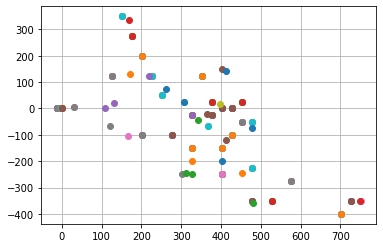

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.grid()
for node in output.scene.nodes:
    pose = node.transforms[0].matrix[:3, 3]
    plt.plot(pose[0], pose[1], 'o')

In [10]:
output.write(f'/home/ruslan/Desktop/meshes/{world_name}.dae')